# Import and prep NY Times time series data for US states and counties

Was originally using Johns Hopkins site for data but seems to be some concern out there about data issues starting when file format changed on March 23. So, will use the newly available NY Times data from https://github.com/nytimes/covid-19-data.

This notebook does the following:

* downloads lates time series data from https://github.com/nytimes/covid-19-data.
* adds an integer day column 
* all dataframes are created both in semi-wide and long forms. The semi-wide forms were date melted in csv but contain separate columns for confirmed and deaths. The long forms are measure melted in addition to date melted.
* csvs explorted to path of your choosing
* basic line plot at bottom for demo.


In [176]:
# Set your data export path to location where exported csvs will go.
data_export_path = './myc19data/'

In [177]:
import os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [178]:
import us # US states and metadata

In [179]:
%matplotlib inline

## Import raw data
The read csv statements below directly access the raw data residing on Github. I've also cloned the repo and can do a `git pull` to update my local copy of the entire repo. However, that is **NOT** necessary to use this notebook.

## Data from NY Times
Here's the URL to the raw data as stored at GitHub:

https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

You can get data directly from here but I'm also including code to grab it from a local repo of the NY Times site. This avoids repeated downloads if you are working on a notebook and keep rerunning all the cells.

In [180]:
# Get data directly from NYTimes
# NYT_counties_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
# NYT_states_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# Using local data that's already been downloaded or git pulled.
local_data_path = os.environ['C19_HOME']
NYT_counties_path = '{}/community/covid-19-data/us-counties.csv'.format(local_data_path)
NYT_states_path = '{}/community/covid-19-data/us-states.csv'.format(local_data_path)

NYT_counties_df = pd.read_csv(NYT_counties_path, parse_dates=['date'])
NYT_states_df = pd.read_csv(NYT_states_path, parse_dates=['date'])

In [181]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [182]:
NYT_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109696 entries, 0 to 109695
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    109696 non-null  datetime64[ns]
 1   county  109696 non-null  object        
 2   state   109696 non-null  object        
 3   fips    108406 non-null  float64       
 4   cases   109696 non-null  int64         
 5   deaths  109696 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.0+ MB


In [183]:
NYT_states_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


### Check dates

In [184]:
num_dates = NYT_states_df['date'].describe()['unique']
print('{} unique dates'.format(num_dates))
date_stats = NYT_states_df['date'].describe()
print(date_stats)

103 unique dates
count                    3369
unique                    103
top       2020-04-30 00:00:00
freq                       55
first     2020-01-21 00:00:00
last      2020-05-02 00:00:00
Name: date, dtype: object


In [185]:
# Add integer day column for simple x-axis 
d0 = date_stats['first']
NYT_counties_df['day'] = NYT_counties_df.loc[:, 'date'].map(lambda x: (x - d0).days)
NYT_states_df['day'] = NYT_states_df.loc[:, 'date'].map(lambda x: (x - d0).days)

## Add state abbreviations
We'll create a mapping dictionary from the `us` package.

In [186]:
us_state_abbrev = us.states.mapping('name', 'abbr')
#us_state_abbrev

In [187]:
NYT_counties_df.loc[:, 'st'] = NYT_counties_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])
NYT_states_df.loc[:, 'st'] = NYT_states_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])

In [188]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,day,st
0,2020-01-21,Snohomish,Washington,53061.0,1,0,0,WA
1,2020-01-22,Snohomish,Washington,53061.0,1,0,1,WA
2,2020-01-23,Snohomish,Washington,53061.0,1,0,2,WA
3,2020-01-24,Cook,Illinois,17031.0,1,0,3,IL
4,2020-01-24,Snohomish,Washington,53061.0,1,0,3,WA


In [189]:
NYT_states_df.loc[NYT_states_df['state'] == 'Virginia'].tail()

,date,state,fips,cases,deaths,day,st
3144,2020-04-28,Virginia,51,14339,492,98,VA
3199,2020-04-29,Virginia,51,14961,522,99,VA
3254,2020-04-30,Virginia,51,15846,552,100,VA
3309,2020-05-01,Virginia,51,16901,581,101,VA
3364,2020-05-02,Virginia,51,17731,616,102,VA


## Compute some first diffs
Be nice to have first diffs of the cumulative counts and some 1-week moving averages. Have to be careful because dataframes are ordered by date by location and direct diffs make no sense. There's also some pandas trickiness with these, especially the rolling means within groups.

In [190]:
NYT_states_df = NYT_states_df.sort_values(by=['state', 'date'])
NYT_states_df['cases_diff'] = NYT_states_df.groupby(['state'])['cases'].diff().fillna(0)
NYT_states_df['cases_ma7'] = NYT_states_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_states_df['deaths_diff'] = NYT_states_df.groupby(['state'])['deaths'].diff().fillna(0)
NYT_states_df['deaths_ma7'] = NYT_states_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())

NYT_counties_df = NYT_counties_df.sort_values(by=['fips', 'date'])
NYT_counties_df['cases_diff'] = NYT_counties_df.groupby(['fips'])['cases'].diff().fillna(0)
NYT_counties_df['cases_ma7'] = NYT_counties_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
# The following is supposed to work but seems that the order isn't right which leads to nonsensical results
# https://stackoverflow.com/questions/53339021/python-pandas-calculate-moving-average-within-group
#NYT_counties_df['moving'] = NYT_counties_df.groupby('fips').rolling(7)['cases'].mean().reset_index(drop=True)
NYT_counties_df['deaths_diff'] = NYT_counties_df.groupby(['fips'])['deaths'].diff().fillna(0)
NYT_counties_df['deaths_ma7'] = NYT_counties_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())

In [191]:
NYT_states_df.head()

,date,state,fips,cases,deaths,day,st,cases_diff,cases_ma7,deaths_diff,deaths_ma7
586,2020-03-13,Alabama,1,6,0,52,AL,0.0,0.000000,0.0,0.0
637,2020-03-14,Alabama,1,12,0,53,AL,6.0,3.000000,0.0,0.0
689,2020-03-15,Alabama,1,23,0,54,AL,11.0,5.666667,0.0,0.0
742,2020-03-16,Alabama,1,29,0,55,AL,6.0,5.750000,0.0,0.0
795,2020-03-17,Alabama,1,39,0,56,AL,10.0,6.600000,0.0,0.0


In [192]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,day,st,cases_diff,cases_ma7,deaths_diff,deaths_ma7
9481,2020-03-24,Autauga,Alabama,1001.0,1,0,63,AL,0.0,0.000000,0.0,0.0
10839,2020-03-25,Autauga,Alabama,1001.0,4,0,64,AL,3.0,1.500000,0.0,0.0
12377,2020-03-26,Autauga,Alabama,1001.0,6,0,65,AL,2.0,1.666667,0.0,0.0
14046,2020-03-27,Autauga,Alabama,1001.0,6,0,66,AL,0.0,1.250000,0.0,0.0
15836,2020-03-28,Autauga,Alabama,1001.0,6,0,67,AL,0.0,1.000000,0.0,0.0


## Rename columns
Sinces cases is actually cumulative cases...

In [193]:
NYT_states_df.rename(columns={'cases': 'cases_cum',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cum',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_counties_df.rename(columns={'cases': 'cases_cum',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cum',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_states_df.head()

,date,state,fips,cases_cum,deaths_cum,day,st,cases,cases_ma7,deaths,deaths_ma7
586,2020-03-13,Alabama,1,6,0,52,AL,0.0,0.000000,0.0,0.0
637,2020-03-14,Alabama,1,12,0,53,AL,6.0,3.000000,0.0,0.0
689,2020-03-15,Alabama,1,23,0,54,AL,11.0,5.666667,0.0,0.0
742,2020-03-16,Alabama,1,29,0,55,AL,6.0,5.750000,0.0,0.0
795,2020-03-17,Alabama,1,39,0,56,AL,10.0,6.600000,0.0,0.0


## Wide to long format by melting the measures

In [194]:
NYT_states_long_df = pd.melt(NYT_states_df, 
  id_vars=['date', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cum', 'deaths_cum', 'cases_ma7', 'deaths_ma7'],
                       var_name='measure', value_name='cases')

NYT_counties_long_df = pd.melt(NYT_counties_df, 
  id_vars=['date', 'county', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cum', 'deaths_cum', 'cases_ma7', 'deaths_ma7'],
                       var_name='measure', value_name='cases')

## Export results

In [195]:
NYT_counties_df.to_csv("{}NYT_counties.csv".format(data_export_path), index=False)
NYT_states_df.to_csv("{}NYT_states.csv".format(data_export_path), index=False)

NYT_counties_long_df.to_csv("{}NYT_counties_long.csv".format(data_export_path), index=False)
NYT_states_long_df.to_csv("{}NYT_states_long.csv".format(data_export_path), index=False)

## Sample plots

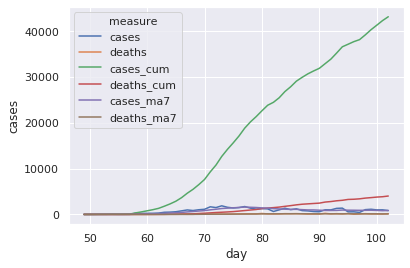

In [196]:
sns.lineplot(x='day', y='cases', hue='measure', 
             data=NYT_states_long_df.loc[NYT_states_long_df['st'] == 'MI']);

In [197]:
se_counties = ['Oakland', 'Macomb', 'Wayne', 'Washtenaw', 'St. Clair', 'Genesee', 'Monroe', 'Lapeer']
semich_df = NYT_counties_df.loc[NYT_counties_df['county'].isin(se_counties) & NYT_counties_df['st'].isin(['MI'])]
semich_df.to_csv('semich_df.csv', index=None)
semich_df

,date,county,state,fips,cases_cum,deaths_cum,day,st,cases,cases_ma7,deaths,deaths_ma7
4745,2020-03-19,Genesee,Michigan,26049.0,1,0,58,MI,0.0,0.000000,0.0,0.000000
5564,2020-03-20,Genesee,Michigan,26049.0,1,0,59,MI,0.0,0.000000,0.0,0.000000
6529,2020-03-21,Genesee,Michigan,26049.0,7,0,60,MI,6.0,0.857143,0.0,0.000000
7607,2020-03-22,Genesee,Michigan,26049.0,14,0,61,MI,7.0,1.857143,0.0,0.000000
8780,2020-03-23,Genesee,Michigan,26049.0,23,0,62,MI,9.0,3.142857,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
96641,2020-04-28,Wayne,Michigan,26163.0,16173,1682,98,MI,301.0,274.000000,60.0,57.714286
99485,2020-04-29,Wayne,Michigan,26163.0,16494,1727,99,MI,321.0,276.142857,45.0,58.285714
102335,2020-04-30,Wayne,Michigan,26163.0,16729,1782,100,MI,235.0,247.857143,55.0,55.142857
105195,2020-05-01,Wayne,Michigan,26163.0,16970,1802,101,MI,241.0,223.285714,20.0,51.285714


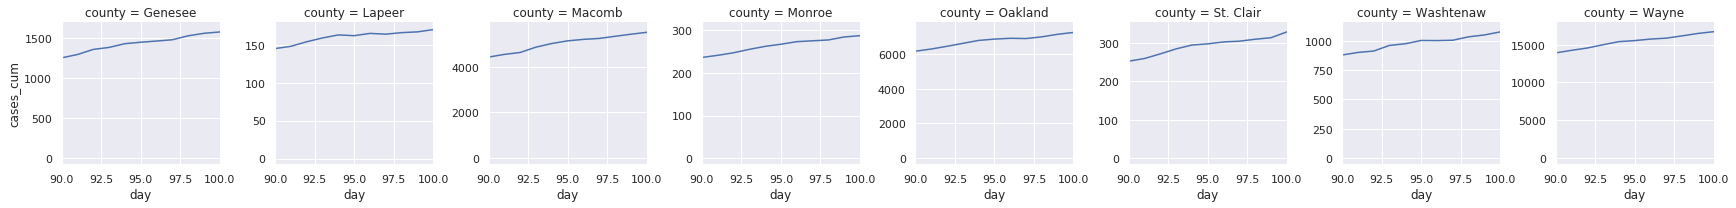

In [198]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_cum")
g.set(xlim=(90,100))

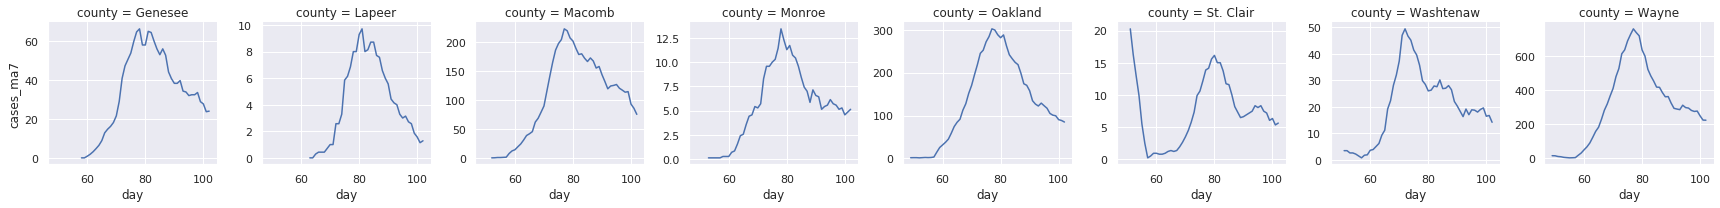

In [200]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7")

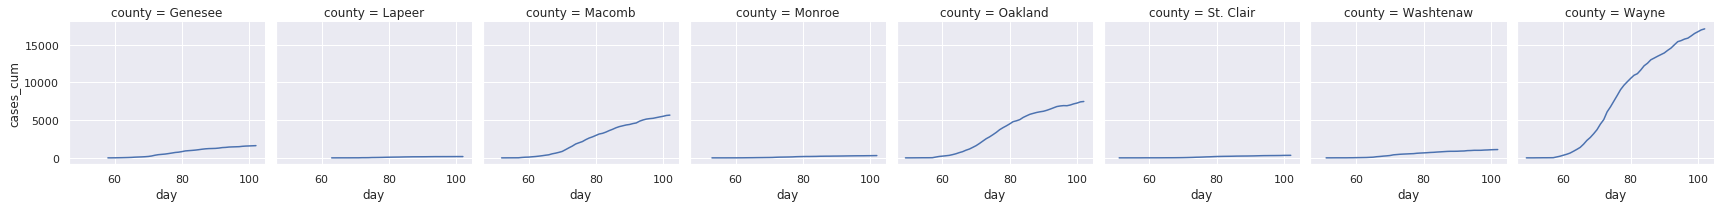

In [201]:
g = sns.FacetGrid(semich_df, col="county", sharey=True)
g = g.map(plt.plot, "day", "cases_cum")

In [206]:
semich_cases_by_date = semich_df.groupby(['date'])[['cases', 'cases_cum']].sum()

In [207]:
semich_cases_by_date.to_csv('semich_cases_by_date.csv')

In [208]:
semich_cases_by_date

,cases,cases_cum
date,,
2020-03-10,0.0,2
2020-03-11,0.0,2
2020-03-12,2.0,7
2020-03-13,9.0,17
2020-03-14,7.0,25
2020-03-15,17.0,42
2020-03-16,1.0,43
2020-03-17,8.0,51
2020-03-18,15.0,66


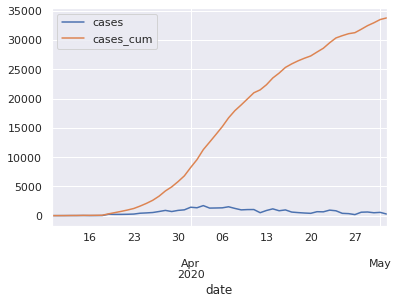

In [209]:
semich_cases_by_date.plot()

In [211]:
some_states = ['MI', 'NY', 'NC', 'FL', 'CA', 'CO', 'GA']
some_states_df = NYT_states_df.loc[NYT_states_df['st'].isin(some_states)]

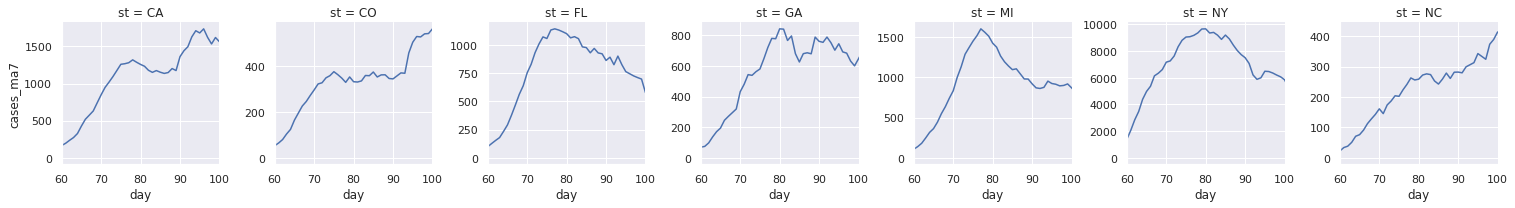

In [212]:
g = sns.FacetGrid(some_states_df, col="st", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7")
g.set(xlim=(60,100))

In [27]:
abbrevs = [state.abbr for state in us.states.STATES]

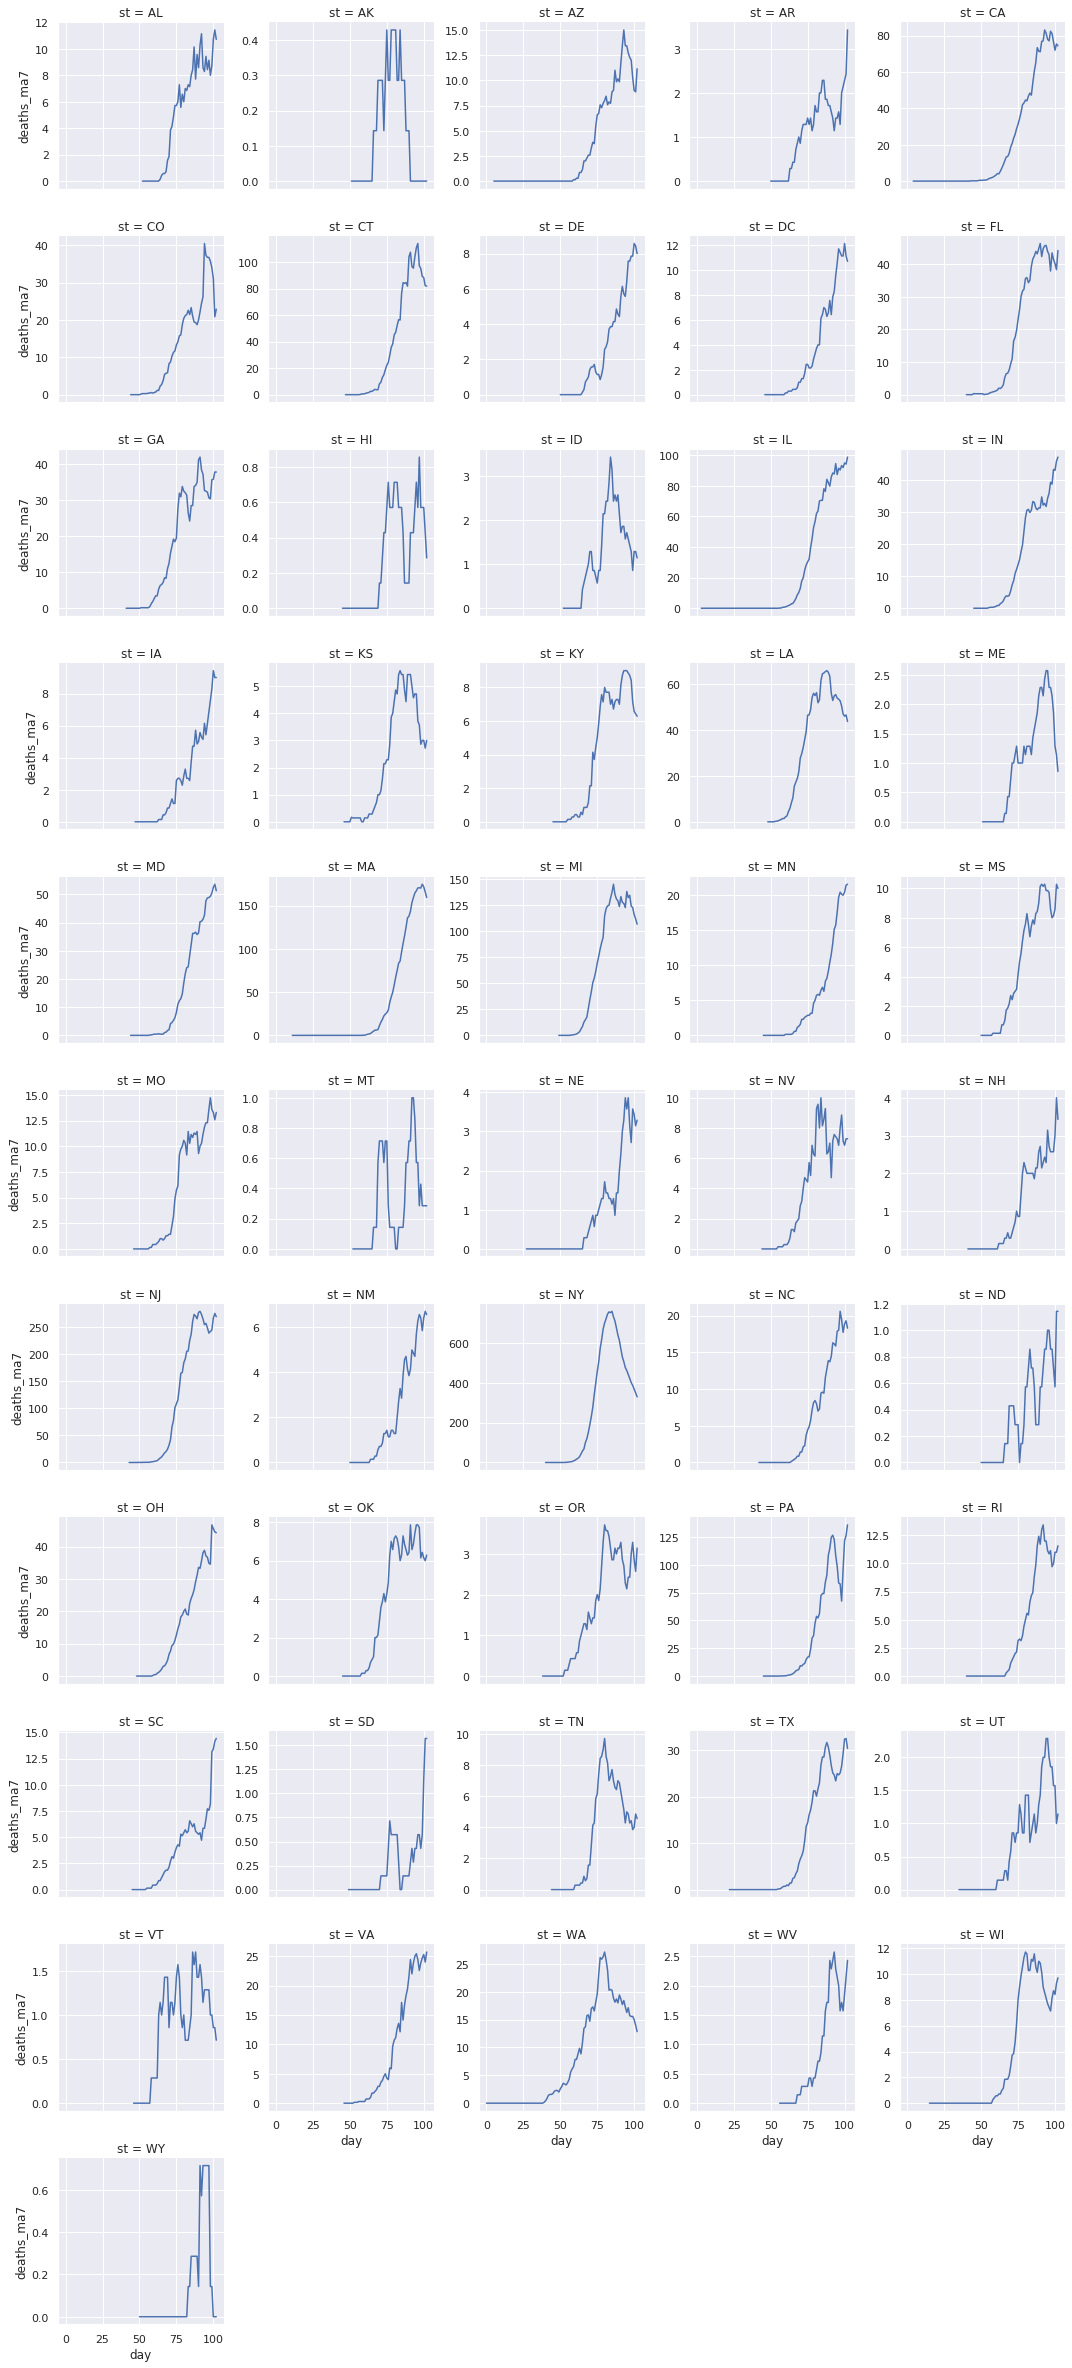

In [213]:
g_states = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states = g_states.map(plt.plot, "day", "deaths_ma7")

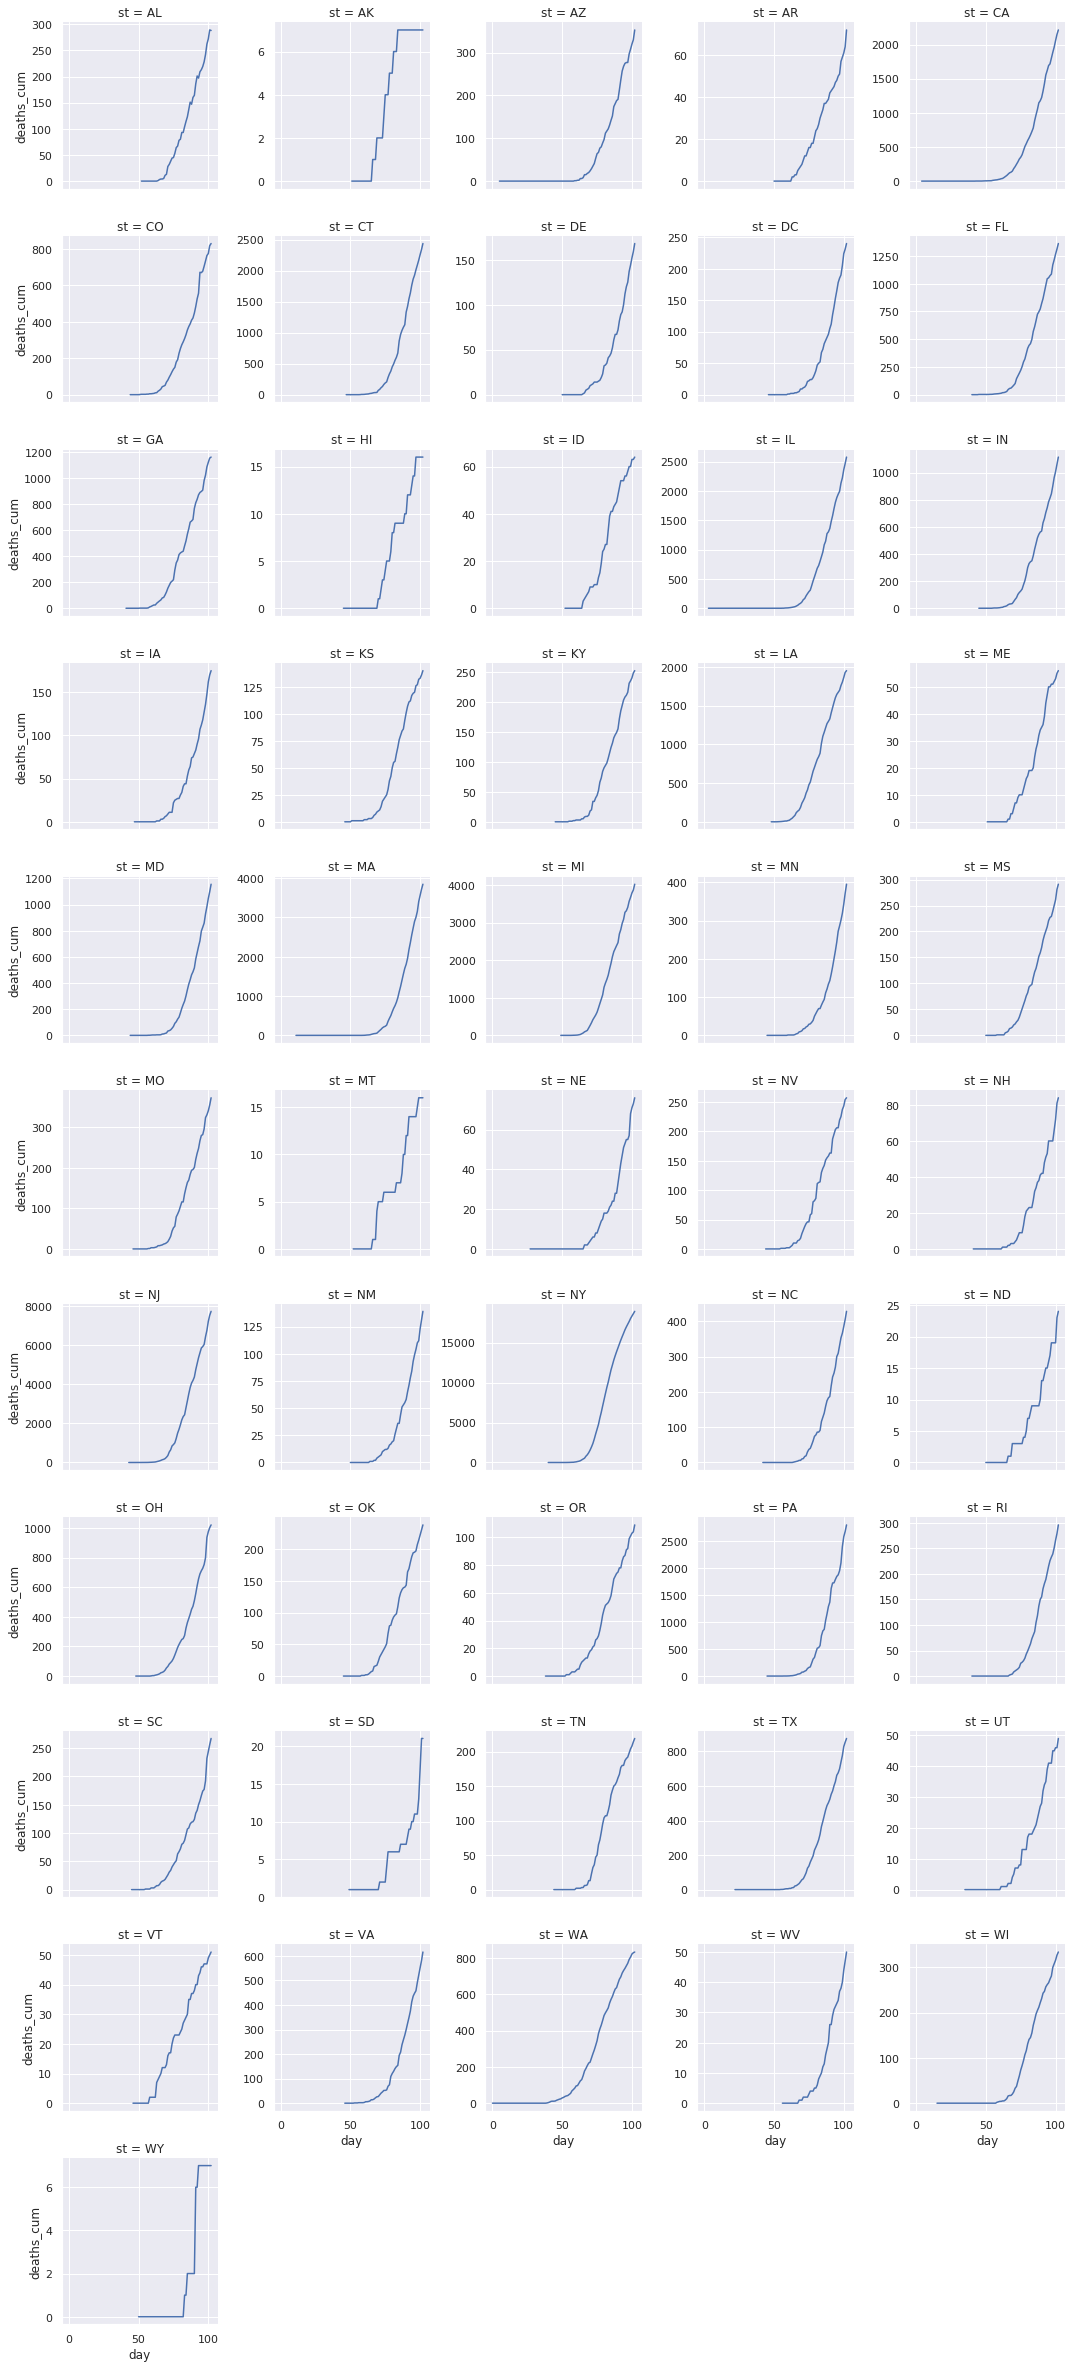

In [214]:
g_states = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states = g_states.map(plt.plot, "day", "deaths_cum")